# Homework 2:  Linear Regression (50 points)

**Reading**: Data8 textbook chapters [15](https://www.inferentialthinking.com/chapters/15/Prediction) and  [16](https://www.inferentialthinking.com/chapters/16/Inference_for_Regression).

Please complete this notebook by filling in the cells provided. Before you begin, execute the following cell to load the needed functions. Each time you start your server, you will need to execute this cell again to load them.

Directly sharing answers is not okay, but discussing problems with the course staff or with other students is encouraged.


Homework 2 is due on Thursday, January 19 at 9:00am. Late work will not be accepted.  

In [82]:
# Don't change this cell; just run it. 
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

In [93]:
# Code we used in Class:
from scipy.optimize import minimize

def standard_units(x):
    "Convert any array of numbers to standard units."
    return (x - np.average(x))/np.std(x,ddof=1)  

def correlation(x, y):
    x_in_standard_units = standard_units(x)
    y_in_standard_units = standard_units(y)
    if len(x)!=len(y):
        raise ValueError('arrays are of different lengths')
    return sum(x_in_standard_units * y_in_standard_units)/(len(x)-1)

def line_mse(x,y):
    if len(x)!=len(y):
        raise ValueError('arrays are of different lengths')
    def mse(a):
        estimate = a[0]*x + a[1]
        return (np.mean((y - estimate) ** 2))
    return minimize(mse,x0=[0,0],method='BFGS')

def slope(x, y):
    if len(x)!=len(y):
        raise ValueError('arrays are of different lengths')
    return  correlation(x, y)* np.std(y,ddof=1)/np.std(x,ddof=1)

def bootstrap_slope(df, x, y, repetitions):
    # the number of observations
    n=df.shape[0]
    # Bootstrap the scatter, find the slope, collect
    slopes = np.array([])
    for i in np.arange(repetitions):
        bootstrap_sample = df.sample(n,replace=True)
        bootstrap_slope = slope(bootstrap_sample[x],bootstrap_sample[y])
        slopes = np.append(slopes, bootstrap_slope)

    # Find the ends of the approximate 95% prediction interval
    left = np.percentile(slopes,2.5)
    right = np.percentile(slopes,97.5)
    
    # Slope of the regression line from the original sample
    observed_slope = slope(df[x],df[y])
    
    print('Slope of regression line:', round(observed_slope,3))
    print('Approximate 95%-confidence interval for the slope of the true line:',round(left,3), 'to', round(right,3))
    

## 1. Birth Weight (41 points) 

The data below contains the following variables for 1,174 mother-baby pairs: the baby’s birth weight in ounces, the number of gestational days, the mother’s age in completed years, the mother’s height in inches, pregnancy weight in pounds, and whether or not the mother smoked during pregnancy.


This dataset was used last quarter, but the only question investigated there was on the association of maternal smoking with birth weight. Here we will try to provide a better understanding of the factors that influence birth weight.

**The variable of interest is Birth Weight.**

In [111]:
# this commands loads the data into a data frame
baby_df=pd.read_csv("baby.csv")
baby_df.head(20)

,Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
0,120,284,27,62,100,False
1,113,282,33,64,135,False
2,128,279,28,64,115,True
3,108,282,23,67,125,True
4,136,286,25,62,93,False
5,138,244,33,62,178,False
6,132,245,23,65,140,False
7,120,289,25,62,125,False
8,143,299,30,66,136,True
9,140,351,27,68,120,False


#### Question 1 ( Visualization, 5 points)

Draw scatter plots of Birth Weight (on the y-axis) versus the four quantitative variables. Also construct a graph that shows the relation between Birth Weight and Maternal Smoker (Hint: boxplots). Comment on what the plots show.

<AxesSubplot:title={'center':'Maternal Pregnancy Weight'}, xlabel='Maternal Pregnancy Weight', ylabel='Birth Weight'>

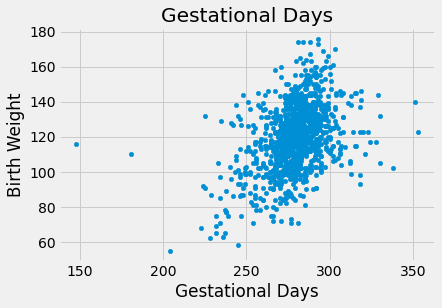

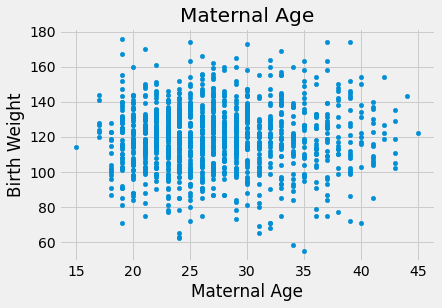

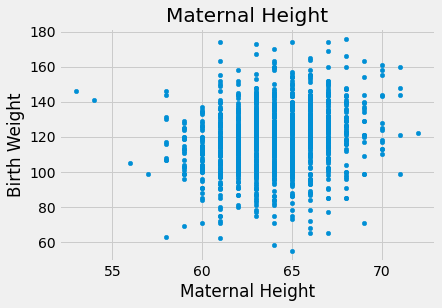

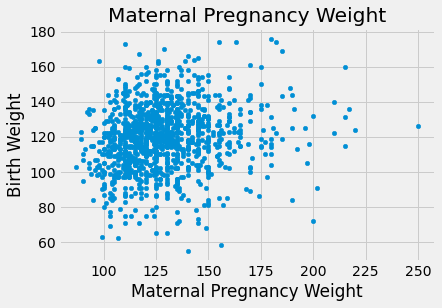

In [46]:
# code here and in additional cells if needed
#fig, axes = plt.subplots(nrows=4, ncols=1)
baby_df.plot.scatter('Gestational Days','Birth Weight',title = 'Gestational Days')
baby_df.plot.scatter('Maternal Age','Birth Weight',title='Maternal Age')
baby_df.plot.scatter('Maternal Height','Birth Weight',title='Maternal Height')
baby_df.plot.scatter('Maternal Pregnancy Weight','Birth Weight',title='Maternal Pregnancy Weight')

Text(0, 0.5, 'Birthweight')

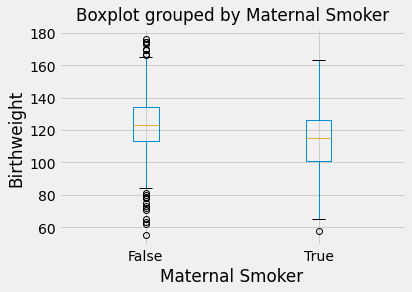

In [67]:
fig, ax1 = plots.subplots()
baby_df.boxplot('Birth Weight','Maternal Smoker',ax = ax1)
#plt.title('Birthweight Boxplot Grouped by Maternal Smoker', fontsize = 12)
ax1.set_title('')
ax1.set_ylabel('Birthweight')

The graphs of the quantitative variables compared to birth rates suggest that there is no clear correlation between those variables and the weight of the baby at birth. The dots in the scatterplots appear to be very scattered and only the Gestational Period comes close to suggesting a very slight positive relationship between the two variables. The boxplot also does not suggest a particularly strong relationship becaues the median of either box does not pass the inner limits of the other. 

#### Question 2 (Simple Linear Regression, Gestational Age, 5 points)

Fit a simple linear regression model for `Gestational Days` (as the predictor) and `Birth Weigth` (as the response). Calculate the intercept, the slope and a 95% Confidence Interval for the slope. Briefly discuss your results by: (i) interpreting the slope; (ii) discussing the signficance of the predictor (is there evidence that the slope is different than 0?); (iii) commenting on whether the results make sense (does it make sense for birth weight to be associated with gestational age?).

**For Questions 2-6, you should write your own code (it is fine to copy functions that we wrote for the class/lecture notebooks); do not use existing regression functions in Python libraries. All relevant code is in class notebooks.**

In [101]:
# code here and in additional cells if needed
# Simple Linear Regression using mean squares
param = line_mse(baby_df['Gestational Days'],baby_df['Birth Weight']).x
print("Slope: ",param[0])
print("Intercept: ",param[1])
bootstrap_slope(baby_df,'Gestational Days','Birth Weight',1000)

Slope:  0.46655537457133367
Intercept:  -10.753720245664555
Slope of regression line: 0.467
Approximate 95%-confidence interval for the slope of the true line: 0.387 to 0.556


The slope of 0.467 implies that for each additional day of the gestational period, the baby's weight at birth increases by 0.467 ounces. 95% of trial slopes lie in the interval 0.384-0.551 so there is a good chance that Gestational period and a baby's birth weight are related. This makes sense because the longer a baby has to grow in the womb, the heavier they should be when born. 

#### Question 3 (Simple Linear Regression, Maternal Age, 5 points)

Repeat Question 2 for Maternal Age.


In [102]:
# code here and in additional cells if needed
param = line_mse(baby_df['Maternal Age'],baby_df['Birth Weight']).x
print("Slope: ",param[0])
print("Intercept: ",param[1])

bootstrap_slope(baby_df,'Maternal Age','Birth Weight',1000)

Slope:  0.08500764511606572
Intercept:  117.14790878267513
Slope of regression line: 0.085
Approximate 95%-confidence interval for the slope of the true line: -0.115 to 0.274


The slope of 0.085 implies that for each additional year that a mother has lived, the weight of their baby will be 0.085 ounces greater. With 95% confidence the true slope of the data lies in the interval -0.084 to 0.271. Because 0 falls within this interval we cannot say with confidence that these variables are related. This makes sense because the age of a mother does not have a large effect on the formation of a baby unless the mother's age is extreme (very young or old), which is rare. 

#### Question 4 (Simple Linear Regression, Maternal Height, 5 points)

Repeat Question 2 for Maternal Height.


In [103]:
# code here and in additional cells if needed
param = line_mse(baby_df['Maternal Height'],baby_df['Birth Weight']).x
print("Slope: ",param[0])
print("Intercept: ",param[1])


bootstrap_slope(baby_df,'Maternal Height','Birth Weight',100)

Slope:  1.4780179473135566
Intercept:  24.796352814903887
Slope of regression line: 1.478
Approximate 95%-confidence interval for the slope of the true line: 1.057 to 1.963


The slope of 1.478 implies that for each additional inch of height that a mother has, their child will be born 1.478 ounces heavier. 95% of sampled slopes of the true slope fall within the interval 1.127 to 1.909, which indicates that there is likely a positive correlation between the two variables. This does make sense in real life as tall parents are likely to have taller children, but a variation of 1.478 still seems quite high. 

#### Question 5 (Simple Linear Regression, Maternal Smoking, 5 points)

Fit a simple linear regression model with `Maternal Smoker` as the predictor (x variable). Recall from class that you need to create a dummy variable for that. Answer the same questions as in Questions 2-4.


In [135]:
# code here and in additional cells if needed
vals = list(baby_df['Maternal Smoker'])
for i in range(len(baby_df['Maternal Smoker'])):
    if vals[i] == True:
        vals[i] = 1
    else:
        vals[i] = 0
baby_df['Adjusted'] = np.array(np.zeros(len(vals)))
baby_df['Adjusted'] = vals
baby_df.head()

param = line_mse(baby_df['Adjusted'],baby_df['Birth Weight']).x
print("Slope: ",param[0])
print("Intercept: ",param[1])
bootstrap_slope(baby_df,'Adjusted','Birth Weight',100)

Slope:  -9.26617138937278
Intercept:  123.08531436436205
Slope of regression line: -9.266
Approximate 95%-confidence interval for the slope of the true line: -10.799 to -7.245


The slope of -9.266 signifies that smoking mothers have children who weigh on average 9.266 less ounces at bith than non-smoking mothers do. There is likely a negative correlationn between the smoking status of mothers and weight of their children at birth. 0 is not in the range of the confidence interval so we can reject the null hypothesis. This makes sense because the weight of a child is often correlated to its health at birth, and children born to smoking mothers are likely to be less healthy at birth. 

Note: This part of the homework (Questions 6 and 7) might use code and ideas discussed on Tuesday 1/17.

#### Question 6 (Multiple Linear Regression, 6 points)

Fit a multiple linear regression with four predictors: Gestational Days, Maternal Smoking, Maternal Height and Maternal Pregagncy Weight. Here you are required only to find the least square parameters (the value of the parameters that minimize the least squares function). Discuss whether these parameters have changed dramatically from when you fitted simple linear regressions (for the three variables for which you did that above). 

In [148]:
# code here and in additional cells if needed
n=baby_df.shape[0]
    
# this is residual sum of squares function
def rss(b):
    estimate = b[0]\
             + b[1]*baby_df['Gestational Days']\
             + b[2]*baby_df['Adjusted']\
             + b[3]*baby_df['Maternal Height']\
             + b[4]*baby_df['Maternal Pregnancy Weight']
    return (np.mean((baby_df['Birth Weight'] - estimate) ** 2))

# the estimated values of the parameters
tmp_fit=minimize(rss,x0=[0,0,0,0,0],method="BFGS").x
print(tmp_fit[0],tmp_fit[1])

-77.26529620907613 0.4371882473937377


The estimated slope and intercept have changed dramatically from the values that were obtained earlier. The slope found -77.265 is much lower than that of any single variable comparison and the intercept is much closer to 0 than in the other comparisons.

#### Question 7 (Prediction and cross validation, 10 points)

The goal here is to construct a model that predicts birth weight. The performance of the models is assessed using "leave one out" cross validation - similarly to what we did in class for the housing data. You should do this for two models: (i) the model in Question 6; (ii) a model of your choice. For the model of your choice, pick something that makes sense to you (you will not be evaluated on whether it predicts better than the model in Question 6).

**For computational reasons (recall the discussion in class), you may do the cross-validation only for a subset of the data, let's say the first 100 subjects.**

**For Question 7 you are allowed to use available regression functions in Python if you find them useful (for computational reasons).**


*Describe your model here, replacing this text.*

In [152]:
# code here and in additional cells if needed
n=baby_df.shape[0]

predicted1 = np.array([])
    
for i in range(100):
    # drop the i-th row
    tmp_df=baby_df.drop(i)

    # the estimated values of the parameters
    tmp_fit=minimize(rss,x0=[0,0,0,0,0],method="BFGS").x

    #the predicted price
    tmp_pred=tmp_fit[0]\
            +tmp_fit[1]*baby_df['Gestational Days'][i]\
            +tmp_fit[2]*baby_df['Adjusted'][i]\
            +tmp_fit[3]*baby_df['Maternal Height'][0]\
            +tmp_fit[4]*baby_df['Maternal Pregnancy Weight'][0]
    
    # appending the result
    predicted1 = np.append(predicted1, tmp_pred)

In [157]:
# the mean absolute deviation for the model above
hund = baby_df.iloc[:100]['Birth Weight']
print(np.mean(abs(hund-predicted1)))

13.02230558587496


In [160]:
# the mean relative error for the model above
print(np.mean(abs(hund-predicted1)/hund))

0.10351612127508997


Text(0, 0.5, 'Predicted Birth Weight')

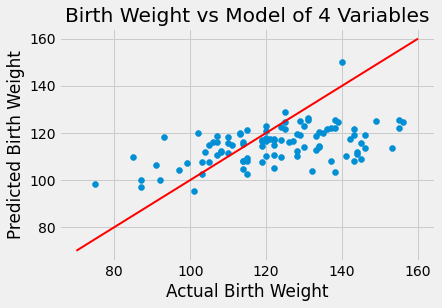

In [172]:
plots.scatter(hund,predicted1)
plots.plot([70,160],[70,160],color="red",lw=2)
plots.title('Birth Weight vs Model of 4 Variables');
plots.xlabel('Actual Birth Weight')
plots.ylabel('Predicted Birth Weight')

In [183]:
#Model 2
predicted2 = np.array([])
def rss(b):
    estimate = b[0]\
         + b[1]*baby_df['Gestational Days']\
         + b[2]*baby_df['Adjusted']
    return (np.mean((baby_df['Birth Weight'] - estimate) ** 2))

for i in range(100):
    # drop the i-th row
    tmp_df=baby_df.drop(i)

    # the estimated values of the parameters
    tmp_fit=minimize(rss,x0=[0,0,0],method="BFGS").x

    #the predicted price
    tmp_pred=tmp_fit[0]\
            +tmp_fit[1]*baby_df['Gestational Days'][i]\
            +tmp_fit[2]*baby_df['Adjusted'][i]\
    
    # appending the result
    predicted2 = np.append(predicted2, tmp_pred)

In [184]:
# the mean absolute deviation for the model above
hund = baby_df.iloc[:100]['Birth Weight']
print(np.mean(abs(hund-predicted2)))

11.99770712609553


In [185]:
# the mean relative error for the model above
print(np.mean(abs(hund-predicted2)/hund))

0.09822493469534944


Text(0, 0.5, 'Predicted Birth Weight')

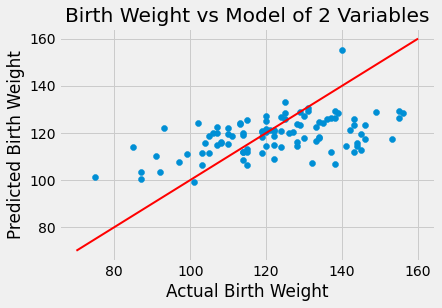

In [186]:
plots.scatter(hund,predicted2)
plots.plot([70,160],[70,160],color="red",lw=2)
plots.title('Birth Weight vs Model of 2 Variables');
plots.xlabel('Actual Birth Weight')
plots.ylabel('Predicted Birth Weight')

The two models both indicate a positive correlation between birth weight and the models used. The absolute deviations from the models (about 12-13) are not insignificant as the interval in which the data falls only spans between about 75 to 160, a range of less than 100. The red slope 1 lines do not fit the data very well, as the actual birth weights seem to vary more than the predicted birth rates. Also the second model, using just Maternal Smoking and Gestestation period as variables appears very similar to the first model, only shifted upwards slightly. This suggests that including Maternal height and Weight reduce the predicted birth weight. 

## 2. Simulations and Confidence Intervals (9 points)

In this exercise we will construct confidence intervals for the population correlation parameter and we will use simulations to assess the validity of our procedure.

The following cell contains a function that generates a dataset of sample size n from a population with correlation parameter equal to r.

In [187]:
def cor_sim(r,n):
    x = np.random.normal(0, 1, n)
    z = np.random.normal(0, 1, n)
    y = r*x + np.sqrt(1 - r**2)*z
    df = pd.DataFrame()
    df['X'] = x
    df['Y'] = y
    return df

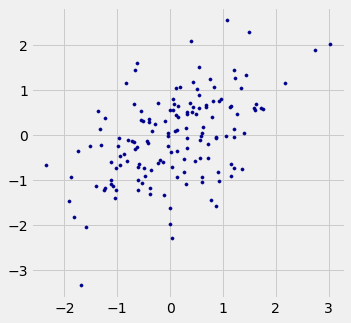

In [188]:
# run this to get a scatter plot of a simulated dataset
sim1_df=cor_sim(0.5,150)

plots.figure(figsize=(5,5))
plots.scatter(sim1_df.X, sim1_df.Y, s=10,c='darkblue');

#### Question 1 (3 points)

Similarly to what we did in Lecture 3 demos, write a function that calculates (for two given variables reflected in two columns of a data frame) a 95% confidence interval for the population correlation. Then calculate a bootstrap 95% CI for a dataset simulated with the function above.

In [197]:
# a function that outputs a 95% CI for the correlation
# input is a data frame, the name of the two columns, and number of bootstraps
# output is an array of length three containing the correlation, and also
# the left and right ends of the 95% CI

def bootstrap_corr(df, x, y, repetitions):
    n=df.shape[0]
    
    correlations = np.array([])
    for i in np.arange(repetitions):
        bootstrap_sample = df.sample(n,replace=True)
        bootstrap_correlation = slope(bootstrap_sample[x], bootstrap_sample[y])
        correlations = np.append(correlations, bootstrap_correlation)
    
    left = np.percentile(correlations,2.5)
    right = np.percentile(correlations,97.5)
    observed_correlation = slope(df[x],df[y])
    return [observed_correlation,left,right]


In [346]:
# run this cell to get the correlation and confidence interval for one simulated dataset

# a simulated data frame with population correlation 0.5
sim1_df=cor_sim(0.5,150)

bootstrap_corr(sim1_df,'X','Y',100)

[0.37569815038180826, 0.2314590440701066, 0.4822851986051609]

#### Question 2 (3 points)

Repeat this procedure 100 times with the same specifications (n=150, r=0.5) and construct a data frame that has 100 rows (one for each simulation) and three columns:

- ObsCor: which contains the observed correlations in each simulated datasets;
- Left: contains the left ends of the 95% confidence intervals;
- Right: contains the right ends of the 95% confidence intervals.

In [349]:
# code here
d = {'ObsCor':np.zeros(100),'Left':np.zeros(100),'Right':np.zeros(100)}
observations = pd.DataFrame(d)
for i in range(100):
    sim1_df=cor_sim(0.5,150)
    param = bootstrap_corr(sim1_df,'X','Y',1000)
    observations['ObsCor'][i] = param[0]
    observations['Left'][i] = param[1]
    observations['Right'][i] = param[2]
observations.head(20)

,ObsCor,Left,Right
0,0.443262,0.311972,0.572754
1,0.511860,0.406722,0.628831
2,0.484727,0.374263,0.600100
3,0.378121,0.219520,0.542107
4,0.455098,0.319068,0.595065
5,0.515157,0.387429,0.646345
6,0.445130,0.336075,0.554793
7,0.541264,0.409588,0.685785
8,0.452994,0.311333,0.569931
9,0.323703,0.161068,0.484641


#### Question 3 (3 points)

Calculate the number of intervals that contain the population value of the correlation (r=0.5). Is this number consistent to your expectation? 

In [350]:
# calculate number of intervals
count = 0
for i in range(100):
    if observations['Left'][i]<=0.5 and observations['Right'][i]>=0.5:
        count+=1
count

94

The number is consistent with expectations. A 95% confidence interval indicates that 95% of intervals will contain the true mean. In the 100 simulations, 94 of the intervals contained the true mean, which is only 1 away from 95. Because we are taking a low number of samples, I believe being 1 off can be accounted for by variance. 